# Import libraries

In [42]:
import sklearn
import ast
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

#Linear model
from sklearn.linear_model import LinearRegression

#KNN
from sklearn.neighbors import KNeighborsRegressor

#RF
from sklearn.ensemble import RandomForestRegressor

#SVR
from sklearn.svm import SVR

#Metrics
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

#Feature selection
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

#Lasso
from sklearn.linear_model import Lasso

#feature selection
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

#Ridge
from sklearn.linear_model import Ridge

#Gradient Boosting 
#lightgbm
import lightgbm as lgb
#catboost
import catboost as ctb
#xgboost
import xgboost as xgb
import matplotlib as mpl

#Neural network
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler


# Download data

In [43]:
data = pd.read_csv('final_data_without_prefs_and_with_HAMADA_factors.csv')
data_ret = pd.read_csv('data_ret.csv')
data_ret.drop(columns=['Unnamed: 0'], inplace=True)
#data_ret.set_index('Date', inplace=True)
data.set_index('Date', inplace = True)
macro_data = pd.read_csv('macro_data.csv')
macro_data.set_index('Date', inplace = True)

ml_results_best_params = pd.read_csv('ML_best_params_ever.csv')
ml_data_1 = pd.read_csv('MSE_result_ever.csv')
ml_data = pd.read_csv('R2_result_ever.csv')

ml_data.set_index('share', inplace=True)
ml_data_1.set_index('share', inplace=True)
ml_results_best_params.set_index('share', inplace=True)

# Random forest feature importance 

In [44]:
lag_autolag_return_30 = 30
lag_autolag_return_60 = 60
lag_autolag_return_90 = 90
lag_30 = 30
lag_60 = 60
lag_90 = 90

A = ['Премия за рыночный риск', 'Доходность самой акции лаг месяц', 'Доходность самой акции лаг 2 месяца',
     'Доходность самой акции лаг 3 месяца',
     'SMB','HML','SMB лаг месяц','HML лаг месяц','SMB лаг 2 месяца','HML лаг 2 месяца',
     'SMB лаг 3 месяца', 'HML лаг 3 месяца', 'MOM', 'MOM лаг месяц','MOM лаг 2 месяца',
     'MOM лаг 3 месяца','Изменение курса доллара за месяц','Изменение цены на нефть за месяц']

B = pd.DataFrame(A).rename(columns={0:'factor'}).set_index('factor')



for name in data_ret.columns[2:]:

    df1 = data[[name, 'Hamada_beta_MRP_for_{}'.format(name[7:11]), 'risk_free_rate_based_on_g_curve',
                     'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
                     'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]),
                     'MOM']].dropna()
    df_autolag = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)})
    df_autolag = pd.DataFrame(df_autolag['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)].shift(lag_autolag_return_30).dropna())

    df_autolag_2 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)})
    df_autolag_2 = pd.DataFrame(df_autolag_2['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)].shift(lag_autolag_return_60).dropna())

    df_autolag_3 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)})
    df_autolag_3 = pd.DataFrame(df_autolag_3['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)].shift(lag_autolag_return_90).dropna())

    df2 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_30).dropna()



    df2.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30), 
                          'MOM':'MOM_lag_{}_days'.format(lag_30)}, inplace = True)

    result = pd.concat([df1, df2], axis=1, join="inner")

    df3 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_60).dropna()

    df3.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60), 
                          'MOM':'MOM_lag_{}_days'.format(lag_60)}, inplace = True)

    result = pd.concat([result, df3], axis=1, join="inner")

    df4 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_90).dropna()

    df4.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90), 
                          'MOM':'MOM_lag_{}_days'.format(lag_90)}, inplace = True)

    result = pd.concat([result, df4], axis=1, join="inner")

    result = pd.merge(result, macro_data, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_2, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_3, left_index=True, right_index=True)
    result['{}_Equity_premium'.format(name[7:14])] = result[name] - result['risk_free_rate_based_on_g_curve']

    share = '{}_Equity_premium'.format(name[7:14])

    print("###############################################")

    print("ML models for {}".format(share))
    dta = result.dropna()

    X_train = dta.iloc[:round(len(dta) - len(dta)/4),:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    X_test = dta.iloc[-round(len(dta)/4):,:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    y_train = dta.iloc[:round(len(dta) - len(dta)/4),:][share]
    y_test = dta.iloc[-round(len(dta)/4):,:][share]
    
    rf = RandomForestRegressor(n_estimators = ast.literal_eval(ml_results_best_params.loc[share,'RF_best_params'])['n_estimators'],
                      max_features=ast.literal_eval(ml_results_best_params.loc[share,'RF_best_params'])['max_features'],
                      min_samples_leaf=ast.literal_eval(ml_results_best_params.loc[share,'RF_best_params'])['min_samples_leaf'],
                      min_samples_split=ast.literal_eval(ml_results_best_params.loc[share,'RF_best_params'])['min_samples_split'],
                      max_depth=ast.literal_eval(ml_results_best_params.loc[share,'RF_best_params'])['max_depth'],
                      bootstrap = ast.literal_eval(ml_results_best_params.loc[share,'RF_best_params'])['bootstrap'])
    rf.fit(X_train, y_train)

    df_2 = pd.DataFrame(rf.feature_importances_, X_train.columns).reset_index().rename(columns={0:'importance_{}'.format(share[:4]),
                                                                                         'index':'factor'})
    df_2['factor'] = A
    df_2.set_index('factor', inplace = True)
    B = pd.concat([B, df_2], axis = 1)
B['средняя важность'] = B.mean(axis=1)
B

###############################################
ML models for SBER_RM_Equity_premium
###############################################
ML models for GAZP_RM_Equity_premium
###############################################
ML models for LKOH_RM_Equity_premium
###############################################
ML models for GMKN_RM_Equity_premium
###############################################
ML models for NVTK_RM_Equity_premium
###############################################
ML models for SNGS_RM_Equity_premium
###############################################
ML models for PLZL_RM_Equity_premium
###############################################
ML models for TATN_RM_Equity_premium
###############################################
ML models for ROSN_RM_Equity_premium
###############################################
ML models for MGNT_RM_Equity_premium
###############################################
ML models for MTSS_RM_Equity_premium
###############################################
ML models for MOE

,importance_SBER,importance_GAZP,importance_LKOH,importance_GMKN,importance_NVTK,importance_SNGS,importance_PLZL,importance_TATN,importance_ROSN,importance_MGNT,...,importance_GCHE,importance_SVAV,importance_MSTT,importance_BSPB,importance_MSRS,importance_KMAZ,importance_RASP,importance_OGKB,importance_VZRZ,средняя важность
factor,,,,,,,,,,,,,,,,,,,,,
Премия за рыночный риск,0.340225,0.743581,0.935204,0.818193,0.801094,0.377429,0.013233,0.867488,0.865053,0.140956,...,0.081371,0.135071,0.101331,0.224767,0.399686,0.146380,0.550670,0.259793,0.057356,0.346773
Доходность самой акции лаг месяц,0.025913,0.015700,0.000171,0.003555,0.007573,0.087496,0.050000,0.000000,0.009518,0.022998,...,0.026540,0.048210,0.015365,0.025234,0.007430,0.032548,0.048175,0.008753,0.009902,0.028902
Доходность самой акции лаг 2 месяца,0.012651,0.013014,0.000764,0.004628,0.003920,0.019474,0.195447,0.000000,0.013585,0.095192,...,0.097935,0.024224,0.010249,0.031397,0.007796,0.089786,0.076186,0.047736,0.018947,0.034753
Доходность самой акции лаг 3 месяца,0.016223,0.007907,0.000000,0.000237,0.000423,0.008479,0.018566,0.000407,0.005520,0.057083,...,0.020870,0.059456,0.037029,0.036815,0.165674,0.052595,0.011595,0.009229,0.043034,0.026672
SMB,0.046576,0.015369,0.000103,0.000999,0.000347,0.032409,0.009745,0.001590,0.016402,0.053620,...,0.010377,0.022400,0.020891,0.027466,0.004495,0.038282,0.008091,0.020725,0.131696,0.032261
HML,0.019889,0.008731,0.000000,0.000663,0.000837,0.035924,0.017447,0.000000,0.002114,0.068228,...,0.019271,0.067565,0.031003,0.026069,0.000647,0.139478,0.010612,0.014364,0.039712,0.029907
SMB лаг месяц,0.024916,0.028807,0.013817,0.005466,0.036571,0.012231,0.092837,0.008081,0.003570,0.054393,...,0.224973,0.108801,0.059242,0.079598,0.000850,0.029479,0.110658,0.100936,0.152503,0.065286
HML лаг месяц,0.045786,0.057728,0.000240,0.055730,0.019254,0.071039,0.011085,0.002698,0.005922,0.066900,...,0.046308,0.033182,0.109553,0.051573,0.002500,0.038663,0.021738,0.202049,0.009007,0.076170
SMB лаг 2 месяца,0.027076,0.014881,0.000389,0.000000,0.007195,0.022722,0.028766,0.000659,0.028016,0.058518,...,0.031421,0.027209,0.023571,0.024001,0.042329,0.045148,0.004191,0.024808,0.015358,0.025799


# Plot the results

In [45]:
K = B.sort_values(by = ['средняя важность'],ascending=False)
fig_1 = go.Figure()


fig_1.add_trace(go.Scatter(x=K.index, y=K['средняя важность'],mode='lines+markers',name='RF'))

fig_1.update_layout(yaxis_title = 'Важность фактора',xaxis_title = 'Фактор',autosize=False,width=1000,height = 700)

fig_1.show()

## Count factor importance for different sectors of economy

### Oil and gas

In [46]:
Neft = B.loc[:,['importance_ROSN', 'importance_LKOH', 'importance_SNGS',
         'importance_NVTK', 'importance_GAZP', 'importance_TATN', 'importance_BANE']]

Neft['средняя важность'] = Neft.mean(axis=1)

### Electric power industry

In [47]:
Electro= B.loc[:,['importance_HYDR', 'importance_FEES', 'importance_IRAO',
         'importance_UPRO', 'importance_RSTI', 'importance_MSNG', 'importance_MSRS', 'importance_OGKB']]

Electro['средняя важность'] = Electro.mean(axis=1)

### Metal and mining sectors

In [48]:
Metal = B.loc[:,['importance_NLMK', 'importance_ALRS', 'importance_GMKN','importance_CHMF', 'importance_PLZL',
          'importance_MAGN', 'importance_TRMK', 'importance_MTLR', 'importance_VSMO', 'importance_RASP']]

Metal['средняя важность'] = Metal.mean(axis=1)

### Finance and banks

In [49]:
Finance = B.loc[:,['importance_SBER', 'importance_MOEX', 'importance_VTBR','importance_AFKS', 'importance_BSPB',
          'importance_VZRZ']]

Finance['средняя важность'] = Finance.mean(axis=1)

### Consumer sector

In [50]:
Consumer = B.loc[:,['importance_MGNT', 'importance_LNTA', 'importance_MVID','importance_GCHE']]

Consumer['средняя важность'] = Consumer.mean(axis=1)

### Chemistry

In [51]:
Chemistry = B.loc[:,['importance_PHOR', 'importance_URKA', 'importance_AKRN','importance_NKNC']]

Chemistry['средняя важность'] = Chemistry.mean(axis=1)

# Plot factor importance by sector

In [52]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=Neft.index, y=Neft['средняя важность'],
                         mode='lines+markers',name='Нефтегазовая отрасль'))

fig.add_trace(go.Scatter(x=Electro.index, y=Electro['средняя важность'],
                         mode='lines+markers',name='Отрасль электроэнергетики'))

fig.add_trace(go.Scatter(x=Metal.index, y=Metal['средняя важность'],
                         mode='lines+markers',name='Металлургическая и добывающая отрасли',
                         line = dict(color='green', width=4, dash='dash')))

fig.add_trace(go.Scatter(x=Finance.index, y=Finance['средняя важность'],
                         mode='lines+markers',name='Финансовая и банковская отрасли',
                         line=dict(color='royalblue', width=4, dash='dot')))
fig.add_trace(go.Scatter(x=Consumer.index, y=Consumer['средняя важность'],
                         mode='lines+markers',name='Потребительская и торговая отрасли',
                         line=dict(color='blue', width=2, dash = 'dot')))

fig.add_trace(go.Scatter(x=Chemistry.index, y=Chemistry['средняя важность'],
                         mode='lines+markers',name='Химическая отрасль',
                         line=dict(color='orange', width=2)))



fig.update_layout(yaxis_title = 'Важность фактора',xaxis_title = 'Фактор',autosize=False,width=1200,height = 1400,
                  legend=dict(yanchor="top", y=0.9, xanchor="right", x=0.9))

fig.show()

# Lasso feature selection

In [53]:
lag_autolag_return_30 = 30
lag_autolag_return_60 = 60
lag_autolag_return_90 = 90
lag_30 = 30
lag_60 = 60
lag_90 = 90

A = ['Премия за рыночный риск', 'Доходность самой акции лаг месяц', 'Доходность самой акции лаг 2 месяца',
     'Доходность самой акции лаг 3 месяца',
     'SMB','HML','SMB лаг месяц','HML лаг месяц','SMB лаг 2 месяца','HML лаг 2 месяца',
     'SMB лаг 3 месяца', 'HML лаг 3 месяца', 'MOM', 'MOM лаг месяц','MOM лаг 2 месяца',
     'MOM лаг 3 месяца','Изменение курса доллара за месяц','Изменение цены на нефть за месяц']

Lasso_selection = pd.DataFrame(A).rename(columns={0:'factor'}).set_index('factor')



for name in data_ret.columns[2:]:
    df1 = data[[name, 'Hamada_beta_MRP_for_{}'.format(name[7:11]), 'risk_free_rate_based_on_g_curve',
                     'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
                     'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]),
                     'MOM']].dropna()
    df_autolag = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)})
    df_autolag = pd.DataFrame(df_autolag['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)].shift(lag_autolag_return_30).dropna())

    df_autolag_2 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)})
    df_autolag_2 = pd.DataFrame(df_autolag_2['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)].shift(lag_autolag_return_60).dropna())

    df_autolag_3 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)})
    df_autolag_3 = pd.DataFrame(df_autolag_3['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)].shift(lag_autolag_return_90).dropna())

    df2 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_30).dropna()



    df2.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30), 
                          'MOM':'MOM_lag_{}_days'.format(lag_30)}, inplace = True)

    result = pd.concat([df1, df2], axis=1, join="inner")

    df3 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_60).dropna()

    df3.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60), 
                          'MOM':'MOM_lag_{}_days'.format(lag_60)}, inplace = True)

    result = pd.concat([result, df3], axis=1, join="inner")

    df4 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_90).dropna()

    df4.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90), 
                          'MOM':'MOM_lag_{}_days'.format(lag_90)}, inplace = True)

    result = pd.concat([result, df4], axis=1, join="inner")

    result = pd.merge(result, macro_data, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_2, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_3, left_index=True, right_index=True)
    result['{}_Equity_premium'.format(name[7:14])] = result[name] - result['risk_free_rate_based_on_g_curve']

    share = '{}_Equity_premium'.format(name[7:14])

    dta = result.dropna()

    X_train = dta.iloc[:round(len(dta) - len(dta)/4),:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    X_test = dta.iloc[-round(len(dta)/4):,:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    y_train = dta.iloc[:round(len(dta) - len(dta)/4),:][share]
    y_test = dta.iloc[-round(len(dta)/4):,:][share]

    lasso = Lasso(alpha = ast.literal_eval(ml_results_best_params.loc[share,'LASSO_best_params'])['alpha'],
                  random_state = ast.literal_eval(ml_results_best_params.loc[share,'LASSO_best_params'])['random_state'],
                  normalize=ast.literal_eval(ml_results_best_params.loc[share,'LASSO_best_params'])['normalize'],
                  tol=ast.literal_eval(ml_results_best_params.loc[share,'LASSO_best_params'])['tol'])

    sfm = SelectFromModel(lasso)

    sfm.fit(X_train, y_train)

    feature_idx = sfm.get_support()
    feature_name = X_train.columns[feature_idx]
    
    df_2 = pd.DataFrame(feature_idx, X_train.columns).reset_index().rename(columns={0:'fact_of_importance_{}'.format(share[:4]),
                                                                                     'index':'factor'})
    df_2['factor'] = A
    df_2.set_index('factor', inplace = True)
    Lasso_selection = pd.concat([Lasso_selection, df_2], axis = 1)

Lasso_selection.replace({True:1, False:0}, inplace = True)
Lasso_selection['Количество попаданий в важные факторы по LASSO'] = Lasso_selection.sum(axis=1)
   
import plotly.graph_objects as go
fig = go.Figure()


fig.add_trace(go.Scatter(x=Lasso_selection.index, y=Lasso_selection['Количество попаданий в важные факторы по LASSO'],
                         mode='lines+markers',name='Количество попаданий в важные факторы по LASSO'))

fig.update_layout(yaxis_title = 'Кол-во попаданий в число важных факторов',xaxis_title = 'Фактор',autosize=False,width=1000,height = 650,
                  legend=dict(yanchor="top", y=0.96, xanchor="left", x=0.01))

fig.show()      

## Lasso feature selection. Number of important factors for each company

In [54]:
M = pd.DataFrame(Lasso_selection.sum(axis=0)).reset_index().rename(columns={'index':'factor', 0:'quantity'})
M = M.iloc[:48,:]
M['factor'] = M['factor'].astype(str).str[-4:]

names = {'SBER':'Сбербанк', 'GAZP':'Газпром', 'LKOH':'Лукойл','GMKN':'Норникель' ,'NVTK':'Новатэк', 'SNGS':'Сургутнефтегаз',
         'PLZL':'Полюс','TATN':'Татнефть','ROSN':'Роснефть','MGNT':'Магнит','MTSS':'МТС', 'MOEX':'МосБиржа', 
         'IRAO':'Интер РАО', 'NLMK':'НЛМК', 'ALRS':'Алроса','CHMF':'Северсталь','VTBR':'ВТБ','RTKM':'Ростелеком',
         'PHOR':'Фосагро','AFKS':'АФК «Система»','MAGN':'ММК','PIKK':'ПИК',
         'HYDR':'Русгидро','FEES':'ФСК ЕЭС','AFLT':'Аэрофлот','LSRG':'ЛСР','RSTI':'Россети','UPRO':'Юнипро',
         'LNTA':'Лента','MVID':'М.Видео','TRMK':'ТМК','MTLR':'Мечел','NMTP':'НМТП','AKRN':'Акрон',
         'MSNG':'Мосэнерго','URKA':'Уралкалий','BANE':'Башнефть','VSMO':'ВСМПО-Ависма','NKNC':'Нижнекамскнефтехим',
         'GCHE':'Черкизово','SVAV':'Соллерс','MSTT':'Мостотрест','BSPB':'Банк Санкт-Петербург', 'MSRS':'МОЭСК',
         'KMAZ':'Камаз','RASP':'Распадская','OGKB':'ОГК №2','VZRZ':'Банк "Возрождение"'}
M.replace({"factor": names}, inplace=True)

fig = go.Figure()


fig.add_trace(go.Scatter(x=M['factor'], y=M['quantity'],
                         mode='lines+markers',name='Количество важных факторов по LASSO'))

fig.update_layout(yaxis_title = 'Количество важных факторов по LASSO',xaxis_title = 'Компания',autosize=False,width=1000,
                  height = 600, legend=dict(yanchor="top", y=0.96, xanchor="left", x=0.01))

fig.show()   

# Analysis of the stability of the importance of factors to different learning algorithms

## XGBoost feature importanc

In [55]:
A = ['Премия за рыночный риск', 'Доходность самой акции лаг месяц', 'Доходность самой акции лаг 2 месяца',
     'Доходность самой акции лаг 3 месяца',
     'SMB','HML','SMB лаг месяц','HML лаг месяц','SMB лаг 2 месяца','HML лаг 2 месяца',
     'SMB лаг 3 месяца', 'HML лаг 3 месяца', 'MOM', 'MOM лаг месяц','MOM лаг 2 месяца',
     'MOM лаг 3 месяца','Изменение курса доллара за месяц','Изменение цены на нефть за месяц']

C = pd.DataFrame(A).rename(columns={0:'factor'}).set_index('factor')



for name in data_ret.columns[2:]:

    df1 = data[[name, 'Hamada_beta_MRP_for_{}'.format(name[7:11]), 'risk_free_rate_based_on_g_curve',
                     'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
                     'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]),
                     'MOM']].dropna()
    df_autolag = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)})
    df_autolag = pd.DataFrame(df_autolag['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)].shift(lag_autolag_return_30).dropna())

    df_autolag_2 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)})
    df_autolag_2 = pd.DataFrame(df_autolag_2['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)].shift(lag_autolag_return_60).dropna())

    df_autolag_3 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)})
    df_autolag_3 = pd.DataFrame(df_autolag_3['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)].shift(lag_autolag_return_90).dropna())

    df2 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_30).dropna()



    df2.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30), 
                          'MOM':'MOM_lag_{}_days'.format(lag_30)}, inplace = True)

    result = pd.concat([df1, df2], axis=1, join="inner")

    df3 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_60).dropna()

    df3.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60), 
                          'MOM':'MOM_lag_{}_days'.format(lag_60)}, inplace = True)

    result = pd.concat([result, df3], axis=1, join="inner")

    df4 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_90).dropna()

    df4.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90), 
                          'MOM':'MOM_lag_{}_days'.format(lag_90)}, inplace = True)

    result = pd.concat([result, df4], axis=1, join="inner")

    result = pd.merge(result, macro_data, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_2, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_3, left_index=True, right_index=True)
    result['{}_Equity_premium'.format(name[7:14])] = result[name] - result['risk_free_rate_based_on_g_curve']

    share = '{}_Equity_premium'.format(name[7:14])

    print("###############################################")

    print("ML models for {}".format(share))
    dta = result.dropna()

    X_train = dta.iloc[:round(len(dta) - len(dta)/4),:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    X_test = dta.iloc[-round(len(dta)/4):,:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    y_train = dta.iloc[:round(len(dta) - len(dta)/4),:][share]
    y_test = dta.iloc[-round(len(dta)/4):,:][share]

    model = xgb.XGBRegressor(n_estimators = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['n_estimators'],
                     colsample_bytree = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['colsample_bytree'],
                     learning_rate = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['learning_rate'],
                     max_depth = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['max_depth'],
                     min_child_weight = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['min_child_weight'],
                     random_state = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['random_state'],
                     reg_alpha = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['reg_alpha'],
                     reg_lambda = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['reg_lambda'],
                     subsample = ast.literal_eval(ml_results_best_params.loc[share,'XGBoost_best_params'])['subsample'])


    model.fit(X_train, y_train)


    df_2 = pd.DataFrame(model.feature_importances_, X_train.columns).reset_index().rename(columns={0:'importance_{}'.format(share[:4]),
                                                                                         'index':'factor'})
    df_2['factor'] = A
    df_2.set_index('factor', inplace = True)
    C = pd.concat([C, df_2], axis = 1)

C['средняя важность'] = C.mean(axis=1)



###############################################
ML models for SBER_RM_Equity_premium
###############################################
ML models for GAZP_RM_Equity_premium
###############################################
ML models for LKOH_RM_Equity_premium
###############################################
ML models for GMKN_RM_Equity_premium
###############################################
ML models for NVTK_RM_Equity_premium
###############################################
ML models for SNGS_RM_Equity_premium


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:695: RuntimeWarning:

invalid value encountered in true_divide



###############################################
ML models for PLZL_RM_Equity_premium
###############################################
ML models for TATN_RM_Equity_premium
###############################################
ML models for ROSN_RM_Equity_premium
###############################################
ML models for MGNT_RM_Equity_premium
###############################################
ML models for MTSS_RM_Equity_premium
###############################################
ML models for MOEX_RM_Equity_premium
###############################################
ML models for IRAO_RM_Equity_premium
###############################################
ML models for NLMK_RM_Equity_premium
###############################################
ML models for ALRS_RM_Equity_premium
###############################################
ML models for CHMF_RM_Equity_premium
###############################################
ML models for VTBR_RM_Equity_premium
###############################################
ML models for RTK

## CatBoost Feature importance

In [56]:
A = ['Премия за рыночный риск', 'Доходность самой акции лаг месяц', 'Доходность самой акции лаг 2 месяца',
     'Доходность самой акции лаг 3 месяца',
     'SMB','HML','SMB лаг месяц','HML лаг месяц','SMB лаг 2 месяца','HML лаг 2 месяца',
     'SMB лаг 3 месяца', 'HML лаг 3 месяца', 'MOM', 'MOM лаг месяц','MOM лаг 2 месяца',
     'MOM лаг 3 месяца','Изменение курса доллара за месяц','Изменение цены на нефть за месяц']

D = pd.DataFrame(A).rename(columns={0:'factor'}).set_index('factor')



for name in data_ret.columns[2:]:

    df1 = data[[name, 'Hamada_beta_MRP_for_{}'.format(name[7:11]), 'risk_free_rate_based_on_g_curve',
                     'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
                     'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]),
                     'MOM']].dropna()
    df_autolag = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)})
    df_autolag = pd.DataFrame(df_autolag['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)].shift(lag_autolag_return_30).dropna())

    df_autolag_2 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)})
    df_autolag_2 = pd.DataFrame(df_autolag_2['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)].shift(lag_autolag_return_60).dropna())

    df_autolag_3 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)})
    df_autolag_3 = pd.DataFrame(df_autolag_3['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)].shift(lag_autolag_return_90).dropna())

    df2 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_30).dropna()



    df2.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30), 
                          'MOM':'MOM_lag_{}_days'.format(lag_30)}, inplace = True)

    result = pd.concat([df1, df2], axis=1, join="inner")

    df3 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_60).dropna()

    df3.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60), 
                          'MOM':'MOM_lag_{}_days'.format(lag_60)}, inplace = True)

    result = pd.concat([result, df3], axis=1, join="inner")

    df4 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_90).dropna()

    df4.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90), 
                          'MOM':'MOM_lag_{}_days'.format(lag_90)}, inplace = True)

    result = pd.concat([result, df4], axis=1, join="inner")

    result = pd.merge(result, macro_data, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_2, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_3, left_index=True, right_index=True)
    result['{}_Equity_premium'.format(name[7:14])] = result[name] - result['risk_free_rate_based_on_g_curve']

    share = '{}_Equity_premium'.format(name[7:14])

    print("###############################################")

    print("ML models for {}".format(share))
    dta = result.dropna()

    X_train = dta.iloc[:round(len(dta) - len(dta)/4),:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    X_test = dta.iloc[-round(len(dta)/4):,:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    y_train = dta.iloc[:round(len(dta) - len(dta)/4),:][share]
    y_test = dta.iloc[-round(len(dta)/4):,:][share]

    model = ctb.CatBoostRegressor(depth = ast.literal_eval(ml_results_best_params.loc[share,'Catboost_best_params'])['depth'],
                     iterations = ast.literal_eval(ml_results_best_params.loc[share,'Catboost_best_params'])['iterations'],
                     learning_rate = ast.literal_eval(ml_results_best_params.loc[share,'Catboost_best_params'])['learning_rate'],
                     l2_leaf_reg = ast.literal_eval(ml_results_best_params.loc[share,'Catboost_best_params'])['l2_leaf_reg'],
                     silent = ast.literal_eval(ml_results_best_params.loc[share,'Catboost_best_params'])['silent'])


    model.fit(X_train, y_train)


    df_2 = pd.DataFrame(model.get_feature_importance(), X_train.columns).reset_index().rename(columns={0:'importance_{}'.format(share[:4]),
                                                                                         'index':'factor'})
    df_2['factor'] = A
    df_2.set_index('factor', inplace = True)
    D = pd.concat([D, df_2], axis = 1)

D['средняя важность'] = D.mean(axis=1)
D['средняя важность'] = D['средняя важность']/D['средняя важность'].sum()



###############################################
ML models for SBER_RM_Equity_premium
###############################################
ML models for GAZP_RM_Equity_premium
###############################################
ML models for LKOH_RM_Equity_premium
###############################################
ML models for GMKN_RM_Equity_premium
###############################################
ML models for NVTK_RM_Equity_premium
###############################################
ML models for SNGS_RM_Equity_premium
###############################################
ML models for PLZL_RM_Equity_premium
###############################################
ML models for TATN_RM_Equity_premium
###############################################
ML models for ROSN_RM_Equity_premium
###############################################
ML models for MGNT_RM_Equity_premium
###############################################
ML models for MTSS_RM_Equity_premium
###############################################
ML models for MOE

## LightGBM feature importanse

In [57]:
A = ['Премия за рыночный риск', 'Доходность самой акции лаг месяц', 'Доходность самой акции лаг 2 месяца',
     'Доходность самой акции лаг 3 месяца',
     'SMB','HML','SMB лаг месяц','HML лаг месяц','SMB лаг 2 месяца','HML лаг 2 месяца',
     'SMB лаг 3 месяца', 'HML лаг 3 месяца', 'MOM', 'MOM лаг месяц','MOM лаг 2 месяца',
     'MOM лаг 3 месяца','Изменение курса доллара за месяц','Изменение цены на нефть за месяц']

E = pd.DataFrame(A).rename(columns={0:'factor'}).set_index('factor')



for name in data_ret.columns[2:]:

    df1 = data[[name, 'Hamada_beta_MRP_for_{}'.format(name[7:11]), 'risk_free_rate_based_on_g_curve',
                     'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
                     'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]),
                     'MOM']].dropna()
    df_autolag = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)})
    df_autolag = pd.DataFrame(df_autolag['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)].shift(lag_autolag_return_30).dropna())

    df_autolag_2 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)})
    df_autolag_2 = pd.DataFrame(df_autolag_2['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)].shift(lag_autolag_return_60).dropna())

    df_autolag_3 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)})
    df_autolag_3 = pd.DataFrame(df_autolag_3['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)].shift(lag_autolag_return_90).dropna())

    df2 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_30).dropna()



    df2.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30), 
                          'MOM':'MOM_lag_{}_days'.format(lag_30)}, inplace = True)

    result = pd.concat([df1, df2], axis=1, join="inner")

    df3 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_60).dropna()

    df3.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60), 
                          'MOM':'MOM_lag_{}_days'.format(lag_60)}, inplace = True)

    result = pd.concat([result, df3], axis=1, join="inner")

    df4 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
            'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_90).dropna()

    df4.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
                          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90), 
                          'MOM':'MOM_lag_{}_days'.format(lag_90)}, inplace = True)

    result = pd.concat([result, df4], axis=1, join="inner")

    result = pd.merge(result, macro_data, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_2, left_index=True, right_index=True)
    result = pd.merge(result, df_autolag_3, left_index=True, right_index=True)
    result['{}_Equity_premium'.format(name[7:14])] = result[name] - result['risk_free_rate_based_on_g_curve']

    share = '{}_Equity_premium'.format(name[7:14])

    print("###############################################")

    print("ML models for {}".format(share))
    dta = result.dropna()

    X_train = dta.iloc[:round(len(dta) - len(dta)/4),:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    X_test = dta.iloc[-round(len(dta)/4):,:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
              '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
              'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
              'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
              'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
              'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
              'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
    y_train = dta.iloc[:round(len(dta) - len(dta)/4),:][share]
    y_test = dta.iloc[-round(len(dta)/4):,:][share]

    model = lgb.LGBMRegressor(boosting_type = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['boosting_type'],
                     colsample_bytree = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['colsample_bytree'],
                     max_depth = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['max_depth'],
                     importance_type = 'gain',
                     learning_rate = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['learning_rate'],
                     random_state = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['random_state'],
                     reg_alpha = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['reg_alpha'],
                     reg_lambda = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['reg_lambda'],
                     subsample = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['subsample'],
                     min_child_samples = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['min_child_samples'],
                     min_child_weight = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['min_child_weight'],
                     n_estimators = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['n_estimators'],
                     num_leaves = ast.literal_eval(ml_results_best_params.loc[share,'Light_GBM_best_params'])['num_leaves'])


    model.fit(X_train, y_train)


    df_2 = pd.DataFrame(model.feature_importances_, X_train.columns).reset_index().rename(columns={0:'importance_{}'.format(share[:4]),
                                                                                         'index':'factor'})
    df_2['factor'] = A
    df_2.set_index('factor', inplace = True)
    E = pd.concat([E, df_2], axis = 1)

E['средняя важность'] = E.mean(axis=1)
E['средняя важность'] = E['средняя важность']/E['средняя важность'].sum()



###############################################
ML models for SBER_RM_Equity_premium
###############################################
ML models for GAZP_RM_Equity_premium
###############################################
ML models for LKOH_RM_Equity_premium
###############################################
ML models for GMKN_RM_Equity_premium
###############################################
ML models for NVTK_RM_Equity_premium
###############################################
ML models for SNGS_RM_Equity_premium
###############################################
ML models for PLZL_RM_Equity_premium
###############################################
ML models for TATN_RM_Equity_premium
###############################################
ML models for ROSN_RM_Equity_premium
###############################################
ML models for MGNT_RM_Equity_premium
###############################################
ML models for MTSS_RM_Equity_premium
###############################################
ML models for MOE

# All importances RF, XGBoost, LightGBM, CatBoost on 1 plot

In [58]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=B.index, y=B['средняя важность'],
                         mode='lines+markers',name='Случайный лес',
                         line = dict(color='blue')))

fig.add_trace(go.Scatter(x=C.index, y=C['средняя важность'],
                         mode='lines+markers',name='XGBoost',
                         line = dict(color='red')))

fig.add_trace(go.Scatter(x=E.index, y=E['средняя важность'],
                         mode='lines+markers',name='Light GBM'))

fig.add_trace(go.Scatter(x=D.index, y=D['средняя важность'],
                         mode='lines+markers',name='CatBoost',
                         line = dict(color='orange', width=2, dash='dash')))


fig.update_layout(yaxis_title = 'Усреднённая по всем компаниям важность фактора',xaxis_title = 'Фактор',autosize=False,width=1000,height = 1100,
                  legend=dict(yanchor="top", y=0.9, xanchor="right", x=0.9))

fig.show()

### Decision tree example for SBER

In [59]:
name = data_ret.columns[2]

df1 = data[[name, 'Hamada_beta_MRP_for_{}'.format(name[7:11]), 'risk_free_rate_based_on_g_curve',
                 'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
                 'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]),
                 'MOM']].dropna()
df_autolag = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)})
df_autolag = pd.DataFrame(df_autolag['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30)].shift(lag_autolag_return_30).dropna())

df_autolag_2 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)})
df_autolag_2 = pd.DataFrame(df_autolag_2['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60)].shift(lag_autolag_return_60).dropna())

df_autolag_3 = pd.DataFrame(data[name] - data['risk_free_rate_based_on_g_curve']).rename(columns = {0:'{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)})
df_autolag_3 = pd.DataFrame(df_autolag_3['{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90)].shift(lag_autolag_return_90).dropna())

df2 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
        'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_30).dropna()



df2.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
                      'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30), 
                      'MOM':'MOM_lag_{}_days'.format(lag_30)}, inplace = True)

result = pd.concat([df1, df2], axis=1, join="inner")

df3 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
        'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_60).dropna()

df3.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
                      'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60), 
                      'MOM':'MOM_lag_{}_days'.format(lag_60)}, inplace = True)

result = pd.concat([result, df3], axis=1, join="inner")

df4 = data[['Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
        'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 'MOM']].shift(lag_90).dropna()

df4.rename(columns = {'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
                      'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]):'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90), 
                      'MOM':'MOM_lag_{}_days'.format(lag_90)}, inplace = True)

result = pd.concat([result, df4], axis=1, join="inner")

result = pd.merge(result, macro_data, left_index=True, right_index=True)
result = pd.merge(result, df_autolag, left_index=True, right_index=True)
result = pd.merge(result, df_autolag_2, left_index=True, right_index=True)
result = pd.merge(result, df_autolag_3, left_index=True, right_index=True)
result['{}_Equity_premium'.format(name[7:14])] = result[name] - result['risk_free_rate_based_on_g_curve']

share = '{}_Equity_premium'.format(name[7:14])

print("###############################################")

print("ML models for {}".format(share))
dta = result.dropna()

X_train = dta.iloc[:round(len(dta) - len(dta)/4),:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
          '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
          '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
          '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
          'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
          'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
          'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
          'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
          'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
          'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
          'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
          'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
          'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
X_test = dta.iloc[-round(len(dta)/4):,:][['Hamada_beta_MRP_for_{}'.format(name[7:11]), 
          '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_30),
          '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_60),
          '{}_premium_lag_{}_days'.format(name[7:], lag_autolag_return_90),
          'Hamada_d_mcap_ratio_SMB_for_{}'.format(name[7:11]),
          'Hamada_d_mcap_ratio_HML_for_{}'.format(name[7:11]), 
          'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_30),
          'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_30),
          'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_60),
          'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_60),
          'Hamada_d_mcap_ratio_SMB_for_{}_lag_{}_days'.format(name[7:11], lag_90),
          'Hamada_d_mcap_ratio_HML_for_{}_lag_{}_days'.format(name[7:11], lag_90),
          'MOM','MOM_lag_{}_days'.format(lag_30),'MOM_lag_{}_days'.format(lag_60),
          'MOM_lag_{}_days'.format(lag_90),'dollar_30d_return','wti_30d_return']]
y_train = dta.iloc[:round(len(dta) - len(dta)/4),:][share]
y_test = dta.iloc[-round(len(dta)/4):,:][share]

###############################################
ML models for SBER_RM_Equity_premium


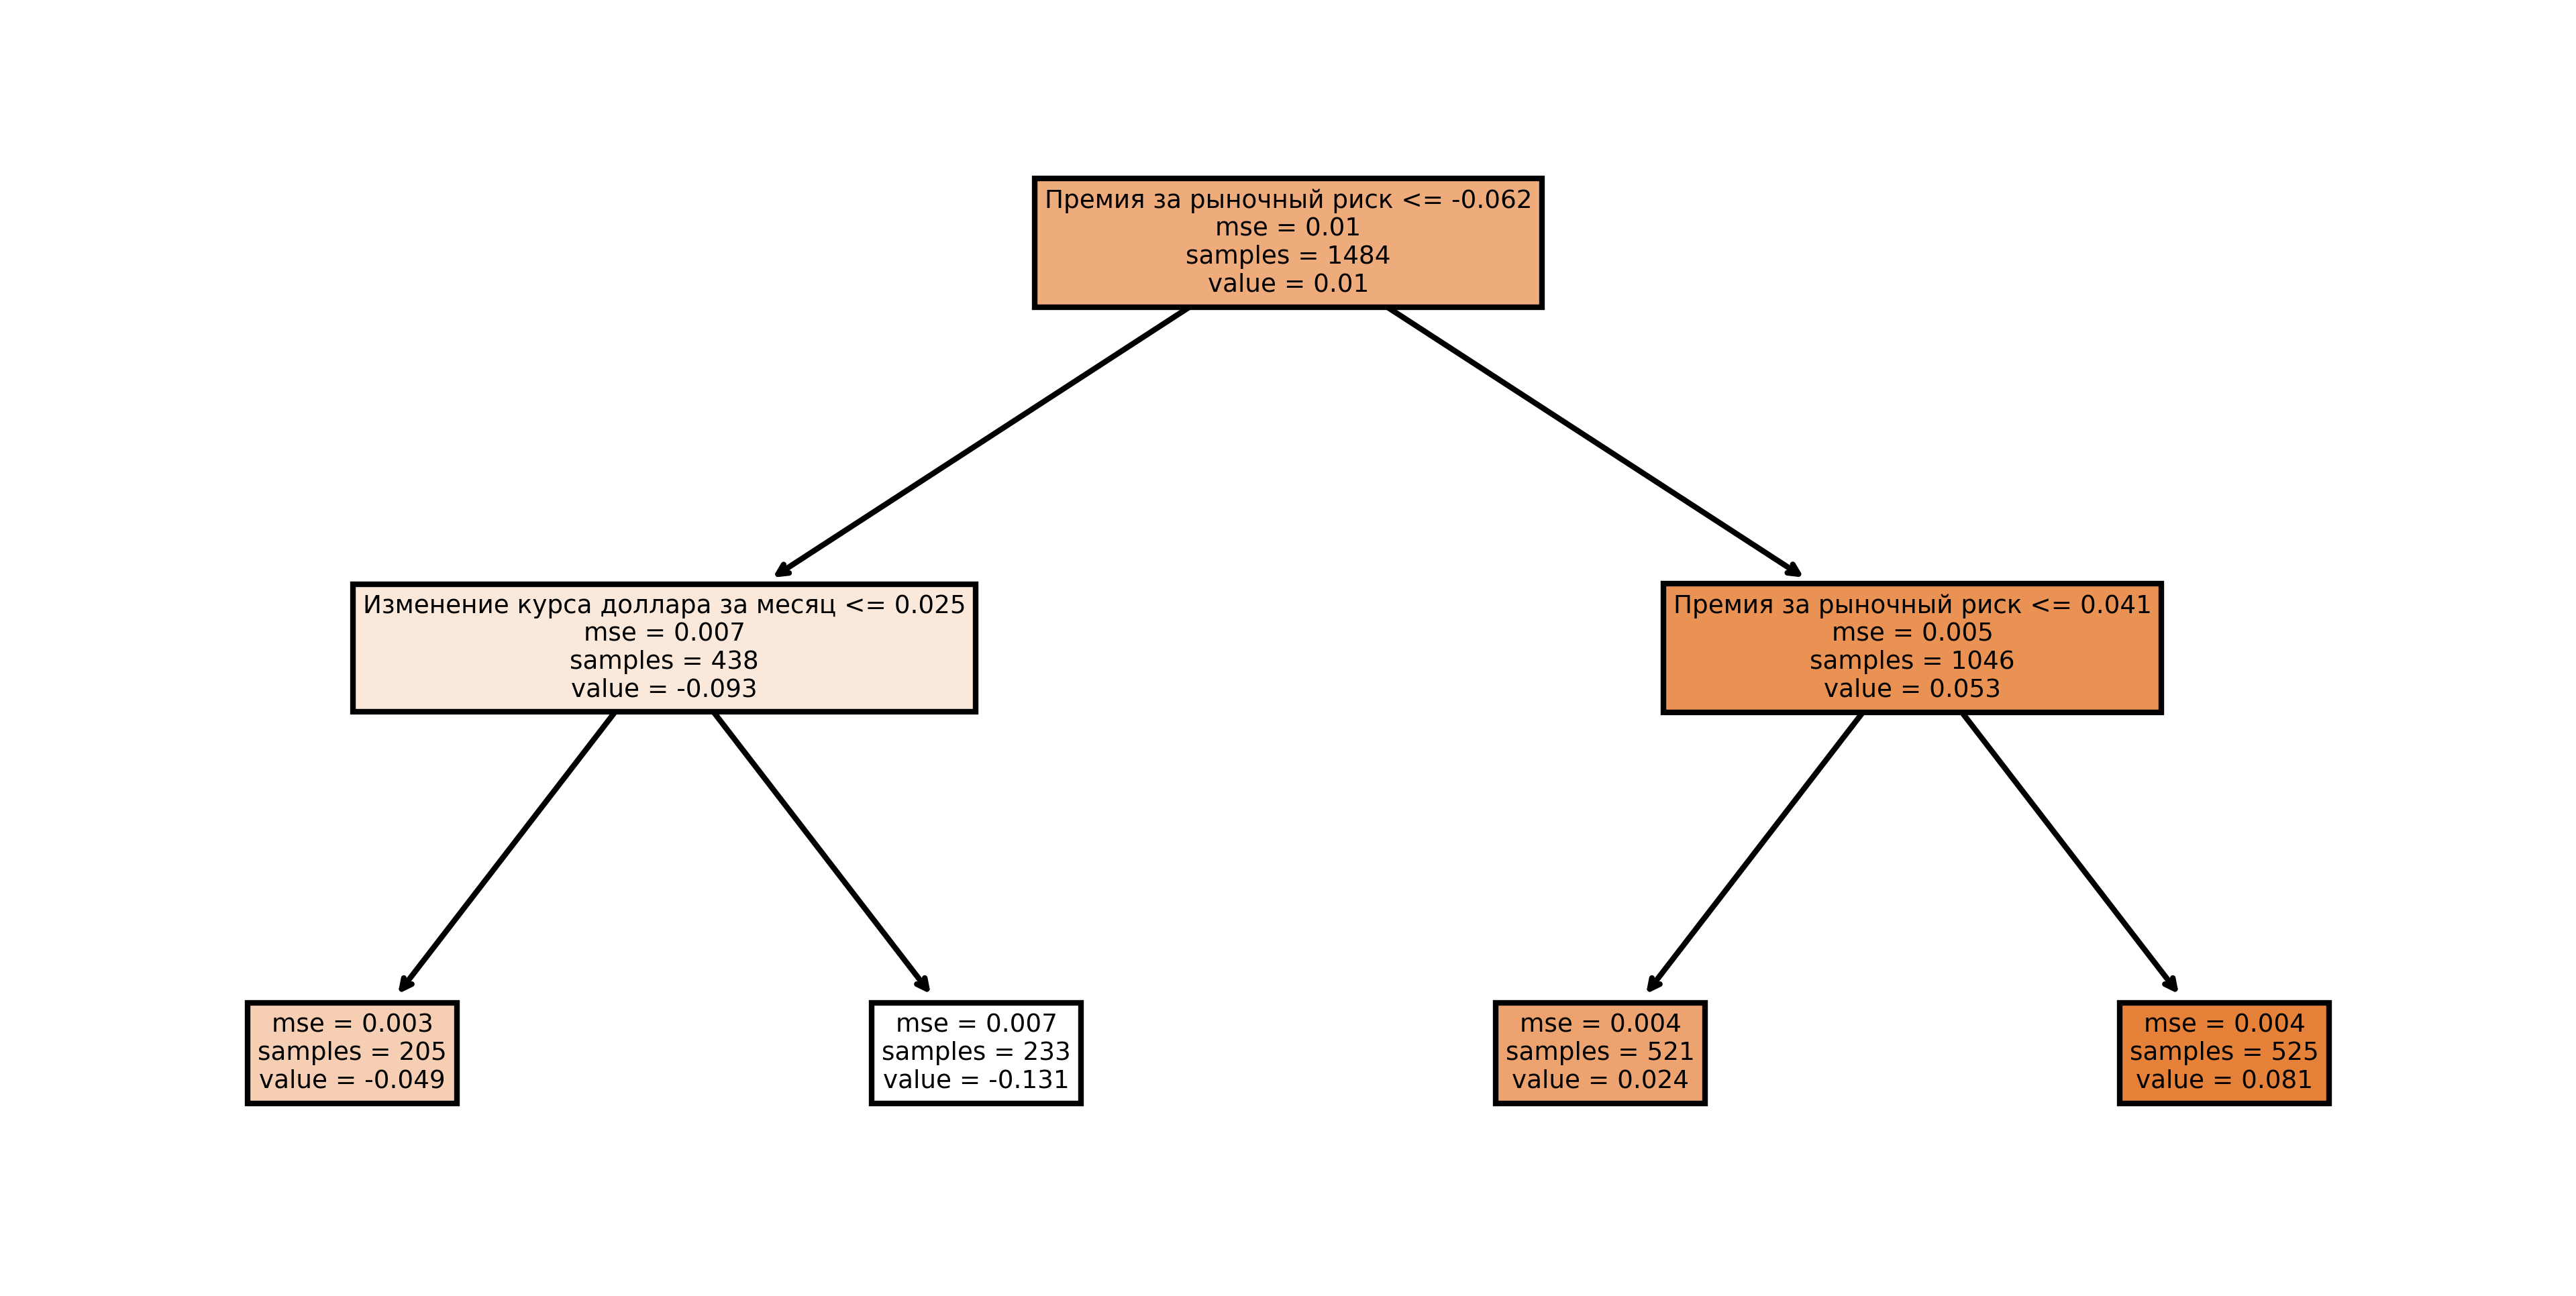

In [60]:
dt = DecisionTreeRegressor(max_depth = 2, min_samples_split = 10,min_samples_leaf = 10, random_state = 42)
dt.fit(X_train, y_train)

fn=A

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,4), dpi=600)

plot_tree(dt,filled = True,feature_names = fn,);
fig.savefig('sber.png')